In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt


In [5]:
df = pd.read_csv("../../data/csv_files/df_ph1.csv")

In [7]:
df['dt'] = pd.to_datetime(df['dt'])

In [9]:
print(df.shape)
df.head()

(7748, 10)


,dt,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,2023-07-28 05:00:00,3.979692,4.231642,4.162819,4.181472,4.128811,5.273175,7.715749,6.417295,3.767151
1,2023-07-28 06:00:00,3.980776,4.233550,4.163253,4.181599,4.129336,5.274380,7.713223,6.418118,3.767072
2,2023-07-28 07:00:00,3.980825,4.236443,4.163040,4.179049,4.129939,5.271060,7.712299,6.417948,3.767076
3,2023-07-28 08:00:00,3.981121,4.236699,4.166883,NaN,4.130379,5.267786,7.712222,6.417735,3.767253
4,2023-07-28 09:00:00,3.981221,4.239193,4.168008,NaN,4.130503,5.265711,7.712381,6.417951,3.767425


In [19]:
stations_name = list(df.columns)
stations_name.remove('dt')

In [21]:
start_array = []
end_array = []
index = 3
start_na = True
print(stations_name[index])

for _, row in df.iterrows():
    if pd.isna(row[stations_name[index]]) and start_na:
        start_na = False
        start_array.append(row['dt'])
    elif not pd.isna(row[stations_name[index]]) and not start_na:
        start_na = True
        end_array.append(row['dt'])

FSB_126


In [23]:
time_duration = {}
for start, end in zip(start_array, end_array):
    time_duration[(start, end)] = pd.to_datetime(end) - pd.to_datetime(start)

In [25]:
for key, value in time_duration.items():
    if value > pd.Timedelta(days= 1):
        print(f"{key}: {value}")

(Timestamp('2023-07-28 08:00:00'), Timestamp('2023-07-31 13:00:00')): 3 days 05:00:00
(Timestamp('2023-07-31 14:00:00'), Timestamp('2023-08-03 22:00:00')): 3 days 08:00:00
(Timestamp('2023-08-04 07:00:00'), Timestamp('2023-08-08 04:00:00')): 3 days 21:00:00
(Timestamp('2023-08-09 11:00:00'), Timestamp('2023-08-13 16:00:00')): 4 days 05:00:00
(Timestamp('2023-08-13 20:00:00'), Timestamp('2023-08-19 05:00:00')): 5 days 09:00:00
(Timestamp('2023-08-19 09:00:00'), Timestamp('2023-08-21 19:00:00')): 2 days 10:00:00
(Timestamp('2023-08-23 20:00:00'), Timestamp('2023-08-28 16:00:00')): 4 days 20:00:00
(Timestamp('2023-08-28 17:00:00'), Timestamp('2023-08-31 07:00:00')): 2 days 14:00:00
(Timestamp('2023-08-31 22:00:00'), Timestamp('2023-10-18 14:45:00')): 47 days 16:45:00
(Timestamp('2024-01-01 01:00:00'), Timestamp('2024-01-24 14:06:00')): 23 days 13:06:00


In [27]:
first_range = ["2023-07-28 05:00:00", "2023-08-31 22:00:00"]
second_range = ["2023-10-18 16:00:00", "2024-01-01 01:00:00"]
third_range = ["2024-01-24 14:06:00", "2024-06-13 01:00:00"]
time_ranges = [first_range, second_range, third_range]


In [29]:
conditions = [((df['dt'] >= start) & (df['dt'] < end)) for start, end in time_ranges]
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition |= condition

new_df = df[combined_condition]
new_df.shape

(6022, 10)

In [31]:
new_df.isna().sum()

dt             0
FEX_004       33
FSB_095DR     65
FSB_078       32
FSB_126      907
FSB_130D     259
FPZ_06A       36
FSB_079       31
FPZ_04A      121
FSB_097D     198
dtype: int64

In [33]:
df_interpolate = new_df.copy()
for col in stations_name:
    df_interpolate[col] = df_interpolate[col].interpolate()

In [35]:
df_interpolate.isna().sum()

dt           0
FEX_004      0
FSB_095DR    0
FSB_078      0
FSB_126      0
FSB_130D     0
FPZ_06A      0
FSB_079      0
FPZ_04A      0
FSB_097D     0
dtype: int64

In [37]:
df_interpolate.head()

,dt,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,2023-07-28 05:00:00,3.979692,4.231642,4.162819,4.181472,4.128811,5.273175,7.715749,6.417295,3.767151
1,2023-07-28 06:00:00,3.980776,4.233550,4.163253,4.181599,4.129336,5.274380,7.713223,6.418118,3.767072
2,2023-07-28 07:00:00,3.980825,4.236443,4.163040,4.179049,4.129939,5.271060,7.712299,6.417948,3.767076
3,2023-07-28 08:00:00,3.981121,4.236699,4.166883,4.179205,4.130379,5.267786,7.712222,6.417735,3.767253
4,2023-07-28 09:00:00,3.981221,4.239193,4.168008,4.179361,4.130503,5.265711,7.712381,6.417951,3.767425


In [39]:
df_interpolate.isna().sum().sum()

0

In [41]:
df_interpolate.shape

(6022, 10)

In [43]:
df_interpolate = df_interpolate.drop(columns = ["dt"])

In [45]:
df_interpolate[:10]

,FEX_004,FSB_095DR,FSB_078,FSB_126,FSB_130D,FPZ_06A,FSB_079,FPZ_04A,FSB_097D
0,3.979692,4.231642,4.162819,4.181472,4.128811,5.273175,7.715749,6.417295,3.767151
1,3.980776,4.233550,4.163253,4.181599,4.129336,5.274380,7.713223,6.418118,3.767072
2,3.980825,4.236443,4.163040,4.179049,4.129939,5.271060,7.712299,6.417948,3.767076
3,3.981121,4.236699,4.166883,4.179205,4.130379,5.267786,7.712222,6.417735,3.767253
4,3.981221,4.239193,4.168008,4.179361,4.130503,5.265711,7.712381,6.417951,3.767425
5,3.980744,4.239561,4.167699,4.179517,4.131535,5.262128,7.713662,6.417348,3.767600
6,3.981171,4.239878,4.170600,4.179673,4.132225,5.259296,7.715626,6.416831,3.767326
7,3.981380,4.240606,4.170594,4.179830,4.131885,5.256999,7.716349,6.416962,3.767770
8,3.982334,4.242422,4.174381,4.179986,4.132148,5.254261,7.717993,6.416275,3.767944
9,3.982292,4.241088,4.175074,4.180142,4.133276,5.252848,7.718636,6.416492,3.768030


In [47]:
def create_overlapping_sequences(df, rows_per_group, overlap):
    sequences = []
    for start in range(0, len(df) - rows_per_group + 1, rows_per_group - overlap):
        seq = df.iloc[start:start + rows_per_group].values.flatten()
        sequences.append(seq)
    return pd.DataFrame(sequences)

In [49]:
reshaped_df = create_overlapping_sequences(df_interpolate, 10, 3)
reshaped_df.shape


(859, 90)

In [51]:
input_array = reshaped_df.values.flatten()
reshaped_input_array = input_array.reshape(-1,9)
reshaped_input_df = pd.DataFrame(reshaped_input_array)

In [53]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(reshaped_df)

In [55]:
tensor_data = torch.tensor(scaled_df, dtype=torch.float32)

dataset = TensorDataset(tensor_data, tensor_data)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [57]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 60),  
            nn.ReLU(),
            nn.Linear(60, 45),        
            nn.ReLU(),
            nn.Linear(45, 30),        
            nn.ReLU(),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(30, 45),         
            nn.ReLU(),
            nn.Linear(45, 60),        
            nn.ReLU(),
            nn.Linear(60, input_dim), 
            nn.Sigmoid()               
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [59]:
input_dim = scaled_df.shape[1]
model = Autoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [60]:
num_epochs = 100
losses = []
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #appending the error to the losses array
    losses.append(loss.item())

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.4791
Epoch [2/100], Loss: 1.1666
Epoch [3/100], Loss: 0.9396
Epoch [4/100], Loss: 0.6093
Epoch [5/100], Loss: 0.8603
Epoch [6/100], Loss: 0.5237
Epoch [7/100], Loss: 0.6977
Epoch [8/100], Loss: 0.6864
Epoch [9/100], Loss: 0.4886
Epoch [10/100], Loss: 0.7175
Epoch [11/100], Loss: 0.8490
Epoch [12/100], Loss: 0.8548
Epoch [13/100], Loss: 0.5594
Epoch [14/100], Loss: 0.5525
Epoch [15/100], Loss: 0.8260
Epoch [16/100], Loss: 0.3087
Epoch [17/100], Loss: 0.6063
Epoch [18/100], Loss: 0.5609
Epoch [19/100], Loss: 0.4085
Epoch [20/100], Loss: 0.7698
Epoch [21/100], Loss: 0.6852
Epoch [22/100], Loss: 0.6483
Epoch [23/100], Loss: 0.5098
Epoch [24/100], Loss: 0.5043
Epoch [25/100], Loss: 0.6999
Epoch [26/100], Loss: 0.6493
Epoch [27/100], Loss: 0.6575
Epoch [28/100], Loss: 0.4990
Epoch [29/100], Loss: 0.8077
Epoch [30/100], Loss: 0.6073
Epoch [31/100], Loss: 0.6710
Epoch [32/100], Loss: 0.7174
Epoch [33/100], Loss: 0.5767
Epoch [34/100], Loss: 0.7517
Epoch [35/100], Loss: 0

In [63]:
model.eval()
with torch.no_grad():
    reconstructed_data = model(tensor_data)
    reconstruction_error = torch.mean((tensor_data - reconstructed_data) ** 2, axis=1).numpy()
print(len(reconstruction_error))

859


In [65]:
reconstructed_np = reconstructed_data.numpy()

In [67]:
predicted_df = pd.DataFrame(reconstructed_np)
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,3.034489e-29,6.223059e-39,9.273186e-15,2.192473e-15,1.056307e-30,0.309941,1.0,0.000002,2.410691e-30,4.498387e-31,...,2.542778e-32,3.427003e-29,0.0,3.268675e-20,6.393475e-15,5.779801e-27,0.287054,1.0,0.000001,6.936846e-31
1,8.163701e-29,2.292736e-38,1.585334e-14,4.408674e-15,3.713495e-30,0.205245,1.0,0.000003,7.238183e-30,1.306875e-30,...,7.375025e-32,9.693969e-29,0.0,5.657510e-20,1.180281e-14,1.707992e-26,0.183994,1.0,0.000001,1.881951e-30
2,1.395766e-28,4.803584e-38,2.013333e-14,5.213965e-15,5.821504e-30,0.267133,1.0,0.000003,1.214009e-29,2.301070e-30,...,1.367437e-31,1.612110e-28,0.0,8.874679e-20,1.444540e-14,2.543552e-26,0.244375,1.0,0.000001,3.435785e-30
3,2.503303e-28,1.068775e-37,2.679792e-14,6.889434e-15,1.063135e-29,0.289249,1.0,0.000003,2.208406e-29,4.289266e-30,...,2.635663e-31,2.872067e-28,0.0,1.362675e-19,1.913573e-14,4.284745e-26,0.265564,1.0,0.000002,6.494455e-30
4,5.527296e-28,3.660473e-37,3.091177e-14,4.054495e-15,8.568121e-30,0.886375,1.0,0.000003,3.507041e-29,9.574632e-30,...,7.616136e-31,4.898912e-28,0.0,4.690905e-19,1.611513e-14,3.790705e-26,0.889895,1.0,0.000001,1.987487e-29


In [69]:
predicted_df = pd.DataFrame(scaler.inverse_transform(predicted_df))

In [71]:
predicted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,4.202438,4.3552,4.29772,4.363318,4.339375,5.271517,8.116474,7.284319,3.992694,4.202549,...,3.993281,4.203098,4.355613,4.297912,4.36382,4.33965,5.267196,8.117151,7.286973,3.99334
1,4.202438,4.3552,4.29772,4.363318,4.339375,5.254917,8.116474,7.284319,3.992694,4.202549,...,3.993281,4.203098,4.355613,4.297912,4.36382,4.33965,5.250856,8.117151,7.286973,3.99334
2,4.202438,4.3552,4.29772,4.363318,4.339375,5.264729,8.116474,7.284319,3.992694,4.202549,...,3.993281,4.203098,4.355613,4.297912,4.36382,4.33965,5.260429,8.117151,7.286973,3.99334
3,4.202438,4.3552,4.29772,4.363318,4.339375,5.268236,8.116474,7.284319,3.992694,4.202549,...,3.993281,4.203098,4.355613,4.297912,4.36382,4.33965,5.263789,8.117151,7.286973,3.99334
4,4.202438,4.3552,4.29772,4.363318,4.339375,5.362914,8.116474,7.284320,3.992694,4.202549,...,3.993281,4.203098,4.355613,4.297912,4.36382,4.33965,5.362775,8.117151,7.286973,3.99334


In [73]:
reshaped_df.head()

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,3.979692,4.231642,4.162819,4.181472,4.128811,5.273175,7.715749,6.417295,3.767151,3.980776,...,3.767944,3.982292,4.241088,4.175074,4.180142,4.133276,5.252848,7.718636,6.416492,3.768030
1,3.981380,4.240606,4.170594,4.179830,4.131885,5.256999,7.716349,6.416962,3.767770,3.982334,...,3.768903,3.985730,4.247343,4.172533,4.181235,4.135252,5.240147,7.718479,6.418277,3.768646
2,3.983771,4.246604,4.176968,4.180923,4.135467,5.238132,7.714308,6.415854,3.768819,3.985819,...,3.769334,3.985763,4.250328,4.175464,4.182329,4.139526,5.267822,7.725976,6.416815,3.769336
3,3.985553,4.249689,4.179306,4.182016,4.138146,5.267761,7.726417,6.416683,3.769159,3.984468,...,3.769413,3.989158,4.259806,4.175162,4.183422,4.143026,5.250044,7.727901,6.416699,3.769520
4,3.986890,4.256864,4.175235,4.183110,4.141998,5.254248,7.726973,6.416566,3.769240,3.988369,...,3.769607,3.986777,4.265368,4.172065,4.184516,4.146350,5.428910,7.717437,6.415808,3.769606


In [75]:
flatten_array = predicted_df.values.flatten()
reshaped_predicted_array = flatten_array.reshape(-1,9)
reshaped_predicted_df = pd.DataFrame(reshaped_predicted_array)
reshaped_predicted_df.head()

,0,1,2,3,4,5,6,7,8
0,4.202438,4.355200,4.297720,4.363318,4.339375,5.271517,8.116474,7.284319,3.992694
1,4.202549,4.355268,4.297694,4.363369,4.339428,5.271864,8.117052,7.285073,3.992815
2,4.202641,4.355325,4.297750,4.363451,4.339289,5.261466,8.116994,7.285603,3.992875
3,4.202648,4.355375,4.297745,4.363540,4.339267,5.261785,8.116702,7.285607,3.992942
4,4.202734,4.355389,4.297850,4.363559,4.339386,5.259318,8.116683,7.285822,3.993003


In [77]:
reshaped_predicted_df.shape

(8590, 9)

In [79]:
index_station = {}
for index, station in enumerate(stations_name):
    index_station[index] = station

index_station

{0: 'FEX_004',
 1: 'FSB_095DR',
 2: 'FSB_078',
 3: 'FSB_126',
 4: 'FSB_130D',
 5: 'FPZ_06A',
 6: 'FSB_079',
 7: 'FPZ_04A',
 8: 'FSB_097D'}

In [81]:
reshaped_predicted_df.rename(columns=index_station, inplace=True)
reshaped_input_df.rename(columns=index_station, inplace = True)
print(reshaped_predicted_df.shape, reshaped_input_df.shape)

(8590, 9) (8590, 9)


In [83]:
reshaped_input_df[stations_name[index]].shape

(8590,)

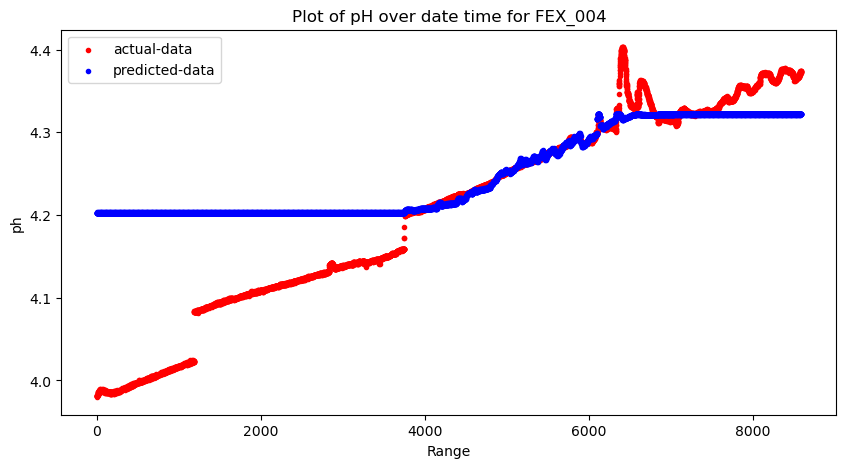

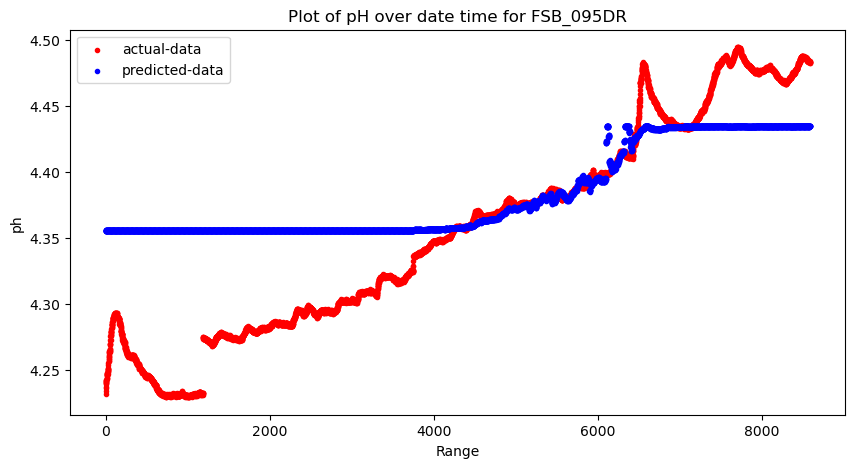

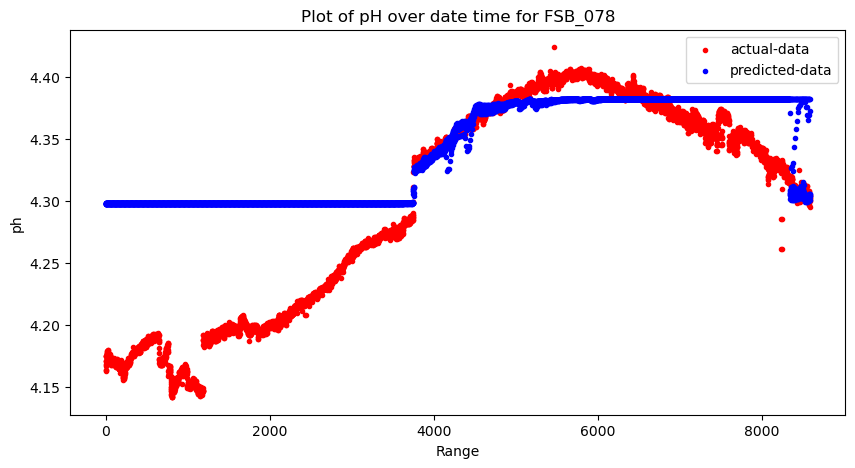

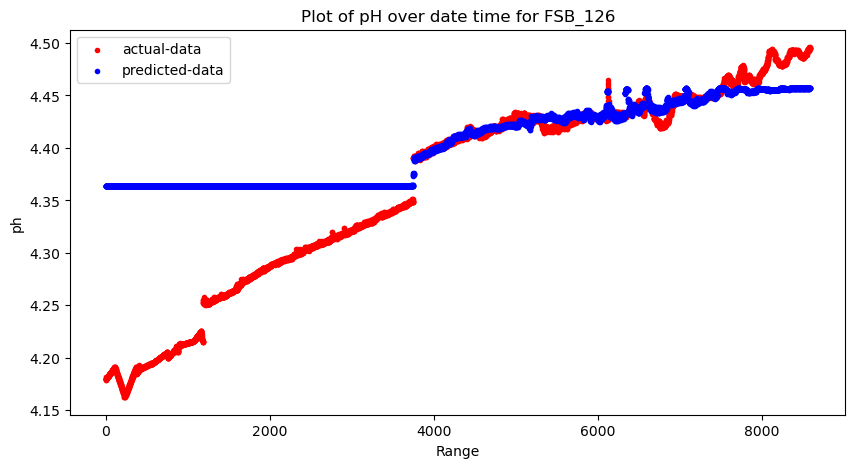

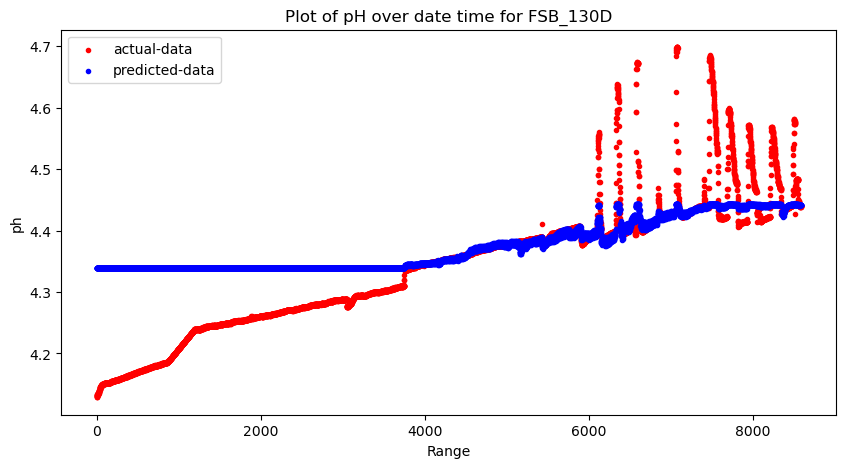

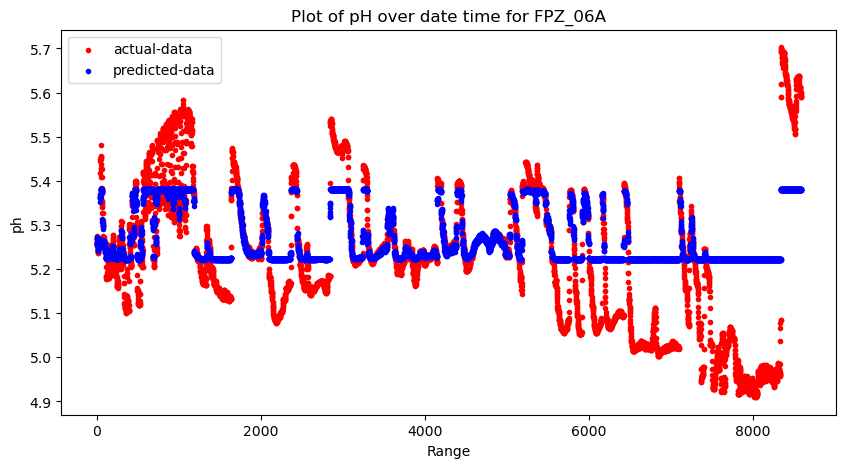

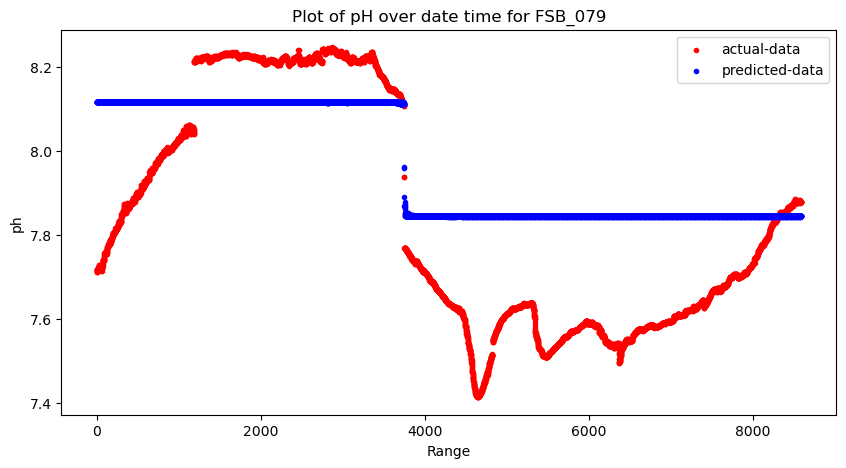

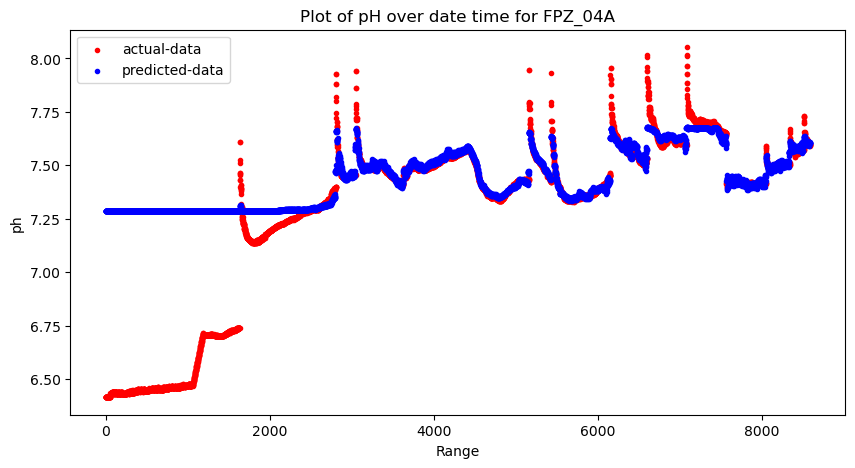

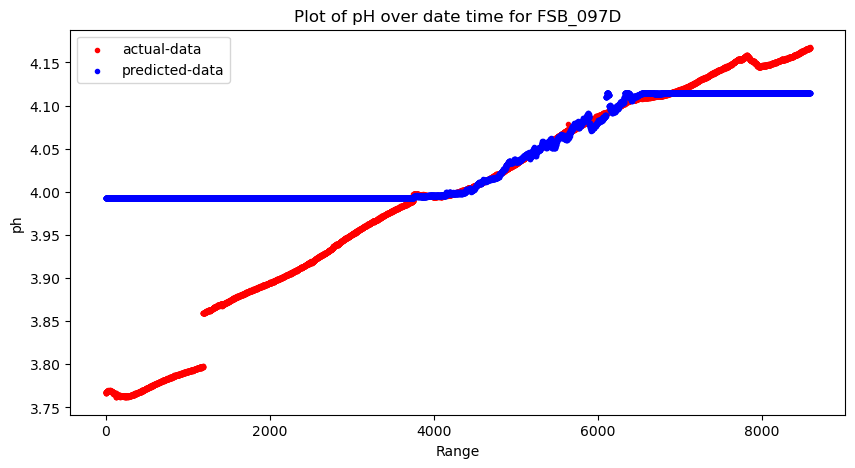

In [85]:
for index,station in enumerate(stations_name):
# index = 0

# print(len(reshaped_input_df[stations_name[index]]))
# print(len(reshaped_predicted_df[stations_name[index]]))
# print(reshaped_input_df[stations_name[index]].shape)
# print(reshaped_predicted_df[stations_name[index]].shape)

    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(reshaped_input_df[stations_name[index]])), reshaped_input_df[stations_name[index]], marker='.', color="red", label="actual-data")
    plt.scatter(range(len(reshaped_predicted_df[stations_name[index]])), reshaped_predicted_df[stations_name[index]], marker='.', color="blue", label = "predicted-data")


    plt.xlabel('Range')
    plt.ylabel('ph')
    plt.title(f'Plot of pH over date time for {stations_name[index]}')
    plt.legend()
    plt.show()
        